## p6

### *Importing Libraries*

In [121]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress = True)

### *preprocessing data*

In [122]:
# Data

with open('./Data/p4.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)### *Data preprocessing (extraction, splitting)*

In [123]:
def convert_to_one_hot(y, num_classes):
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[np.arange(y.shape[0]), y] = 1
    return y_one_hot

In [124]:
def preprocess_data(X):
    y = X[:, 0].astype(int)
    x = np.delete(X, 0, axis = 1)
    return x, y

In [125]:
# Splits the data with given percentages

def DataSplit(Data, train_percent, test_percent, val_percent = 0):
    split_list = []
    train_size = int(train_percent * Data.shape[0] / 100)
    val_size = int(val_percent * Data.shape[0] / 100)
    test_size = Data.shape[0] - train_size - val_size
    
    # Train and Test data
    DTrain = np.zeros((train_size, Data.shape[1]))
    DTest = np.zeros((test_size, Data.shape[1]))
    DTrain = Data[0:train_size, :]
    DTest = Data[train_size + val_size: Data.shape[0], :]
    split_list.extend([DTrain, DTest])
    
    # For validataion data
    if val_percent > 0:
        DVal = np.zeros((val_size, Data.shape[1]))
        DVal = Data[train_size: train_size + val_size, :]
        split_list.append(DVal)
    return split_list

In [126]:
Data = np.array(results)
labels = np.unique(Data[:,0].astype(int))
input_features = Data.shape[1] - 1

In [127]:
print(Data.shape)
print(input_features)

(60000, 785)
784


In [128]:
split_data = DataSplit(Data, 2, 96, 2)
### *Config - 1 (1 Hidden Layer with 350 neurons)*
# Train and Test Data
DTrain = split_data[0]
DTest = split_data[1]
# Validataion Data
if len(split_data) == 3:
    DVal = split_data[2]

In [129]:
print(DTrain.shape)
print(DVal.shape)
print(DTest.shape)

(1200, 785)
(1200, 785)
(57600, 785)


### *Activations*

In [130]:
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output
    def backward(self):
        # Here not necessasry to copy the values as we are only using dvalues once
        self.dinputs = np.ones_like(self.inputs)
        # When the inputs to relu are not positve, make the dinputs zero
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

In [131]:
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probabilities
        return self.output
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        return self.dinputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis = 1)

### *Optimizer*

In [132]:
class Optimizer_SGD: 
    def __init__(self, learning_rate = 1, decay = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0 
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)
    def update_params(self, layer):
        if isinstance(layer, Layer_Convolution):
            layer.kernel_weights += -self.current_learning_rate * layer.dweights
        if isinstance(layer, Layer_FullyConnected):
            layer.weights += -self.current_learning_rate * layer.dweights
            layer.biases += -self.current_learning_rate * layer.dbiases   
    def post_update_params(self):
        self.iterations += 1

### *CrossEntropy Loss with Softmax Layer*

In [133]:
class Softmax_CrossEntropyLoss:

    def forward(self, y_pred, y_true, classes):
        
        # y_pred shape: (batch_size, num_classes)
        # y_true shape: (batch_size,)
        batch_size = y_pred.shape[0]
        # Clip y_pred values to prevent log(0) errors
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the log of predicted probabilities for the true class for each example
        log_likelihoods = -np.log(y_pred[range(batch_size), y_true])
        # Compute the mean of the log likelihoods for the batch
        loss = np.mean(log_likelihoods)
        return loss
    
    def backward(self, dvalues, y_true, classes):
          # Number of samples
        samples = len(dvalues)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs

### *Input Layer*

In [134]:
class Layer_ConvInput:
    def forward(self, X):
        self.output = X
        return self.output

### *Fully Connected Layer*

In [135]:
### *Fully Connected Layer*

class Layer_FullyConnected:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        
        #Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))   

    def forward(self, inputs):
        
        # calculate the values of the neurons before activation
        # inputs matrix contains features for a sample of data
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights) + self.biases
        return self.output
    
    def backward(self, dvalues, regularizer = 0):
        
        # dvalues are the upstream gradients
        # dweights, dbiases are the backprop gradients with shape similar to weights matrix and bias vector
        # dinputs are the dvalues for the previous layer with shape similar to inputs
        self.dweights = np.dot(self.inputs.T, dvalues) + 2 * regularizer * self.weights
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

### *Convolution Layer*

In [136]:
class Layer_Convolution:
    
    def __init__(self, kernel_num, kernel_size, input_channels):
        
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.input_channels = input_channels
        self.kernel_weights = np.random.randn(kernel_num, kernel_size, kernel_size, input_channels) / (kernel_size**2)
    
    def patch_generator(self, inputs):
        
        self.inputs = inputs
        batch_size, height, width, channels = inputs.shape
        for b in range(batch_size):
            for h in range(height - self.kernel_size + 1):
                for w in range(width - self.kernel_size + 1):
                    patch = self.inputs[b, h:(h + self.kernel_size), w:(w + self.kernel_size), :]
                    yield patch, b, h, w
    
    def forward(self, inputs):
        
        batch_size, height, width, channels = inputs.shape
        self.layer_output = np.zeros((batch_size, height - self.kernel_size + 1, width - self.kernel_size + 1, self.kernel_num))
        for patch, b, h, w in self.patch_generator(inputs):
            self.layer_output[b, h, w] = np.sum(patch * self.kernel_weights, axis=(1,2,3))
        return self.layer_output

    def backward(self, dvalues, regularizer = 0):
        
        self.dinputs = np.zeros(self.inputs.shape)
        self.dweights = np.zeros(self.kernel_weights.shape)
        for patch, b, h, w in self.patch_generator(self.inputs):
            for k in range(self.kernel_num):
                self.dinputs[b, h:h + self.kernel_size, w:w + self.kernel_size, :] += self.kernel_weights[k] * dvalues[b, h, w, k]
                self.dweights[k] += patch * dvalues[b, h, w, k]
        self.dweights += 2 * regularizer * self.kernel_weights

        return self.dinputs

### *Max Pooling Layer*

In [137]:
class Layer_Maxpool:
    
    def __init__(self, kernel_size):

        self.kernel_size = kernel_size

    def patch_generator(self, image):

        patch_h = image.shape[1] // self.kernel_size
        patch_w = image.shape[2] // self.kernel_size
        batch_size = image.shape[0]

        for i in range(batch_size):  
            batch_patches = []
            for h in range(patch_h):
                for w in range(patch_w):
                    patch = image[i, (h * self.kernel_size):(h * self.kernel_size + self.kernel_size), (w * self.kernel_size):(w * self.kernel_size + self.kernel_size), :]
                    batch_patches.append(patch)
            yield np.array(batch_patches), i
    
    def forward(self, inputs):
        
        self.inputs = inputs
        batch_size, height, width, channels = self.inputs.shape
        self.layer_output = np.zeros((batch_size, height // self.kernel_size, width // self.kernel_size, channels))
        for batch_patches, i in self.patch_generator(inputs):
            self.layer_output[i] = np.amax(batch_patches, axis = (1,2)).reshape(height // self.kernel_size, width // self.kernel_size, channels)
        return self.layer_output

    def backward(self, dvalues, dvalue_activation):

        dvalues = dvalues.reshape(self.layer_output.shape)
        self.dinputs = np.zeros(self.inputs.shape)
        for batch_patches, i in self.patch_generator(self.inputs):
            batch_size, image_h, image_w, num_channels = batch_patches.shape
            max_val = np.amax(batch_patches, axis=(1,2))

            for h in range(image_h):
                for w in range(image_w):
                    for idx_k in range(num_channels):
                        for b in range(batch_size):
                            if batch_patches[b,h,w,idx_k] == max_val[b,idx_k]:
                                self.dinputs[i, h*self.kernel_size:h*self.kernel_size+self.kernel_size, w*self.kernel_size:w*self.kernel_size+self.kernel_size, idx_k] += dvalues[i, h, w, idx_k] * dvalue_activation[i, h*self.kernel_size:h*self.kernel_size+self.kernel_size, w*self.kernel_size:w*self.kernel_size+self.kernel_size, idx_k]
        return self.dinputs

### *ConvNet Class*

In [138]:
class ConvNet:
    
    def __init__(self, input_channels, conv_filters, conv_kernel_size, pool_kernel_size, fc_layer_inputs, output_neurons, learning_rate):
        
        # Layers
        self.input_channels = input_channels
        self.hidden_layers = []
        self.loss_fn = Softmax_CrossEntropyLoss()
        self.train_loss = []
        self.val_loss = []
        self.optimizer = Optimizer_SGD(learning_rate, decay = 0)
        self.input_layer = Layer_ConvInput()
        for i, conv_filter in enumerate(conv_filters):
            input_channels = input_channels if i == 0 else conv_filters[i - 1]
            conv_layer = Layer_Convolution(conv_filters[i], conv_kernel_size, input_channels)
            pool_layer = Layer_Maxpool(pool_kernel_size)
            activation_layer = Activation_ReLU() 
            self.hidden_layers.extend([conv_layer, pool_layer, activation_layer])
            
        self.output_layer = Layer_FullyConnected(fc_layer_inputs, output_neurons)
        self.output_softmax_layer = Activation_Softmax()

    def forward(self, x):
        x = self.input_layer.forward(x)
        for layer in self.hidden_layers:
            x = layer.forward(x)
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.output_layer.forward(x)
        x = self.output_softmax_layer.forward(x)
        return x

    def backward(self, y_pred, y_true, classes, regularizer = 0):
        
         # Compute the derivative of the loss with respect to the output of the model
        
        dL_dy = self.loss_fn.backward(y_pred, y_true, classes)
        
         # backpropagate the derivatives through the output layer
            
        dL_dx = self.output_layer.backward(dL_dy, regularizer)
        temp = None
        for layer in reversed(self.hidden_layers):
            if isinstance(layer, Activation_ReLU):
                temp = layer.backward()
            elif isinstance(layer, Layer_Maxpool):
                dL_dx = layer.backward(dL_dx, temp)
            else:
                dL_dx = layer.backward(dL_dx, regularizer)
    
    def train_earlystop(self, X, epochs, batch_size, Y):
        
        val_loss_list = []
        for epoch in range(epochs):
            
            np.random.shuffle(X)
            classes = np.unique(X[:, 0].astype(int))
            train_accuracy = 0
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:min(X.shape[0], i + batch_size), :]
                x_batch, y_batch = preprocess_data(batch)
                x_batch = x_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                train_accuracy += np.count_nonzero(predictions == y_batch)
                
                # Backward pass 
                self.backward(outputs, y_batch, classes)
                    
                for layer in self.hidden_layers:
                    self.optimizer.pre_update_params()
                    self.optimizer.update_params(layer)
                    self.optimizer.post_update_params()
                self.optimizer.update_params(self.output_layer)
#             self.calculate_loss(X)
            print('Epoch: ', epoch + 1, 'Train Accuracy: ', round(train_accuracy * 100 / len(X), 2), 'Train Loss: ', self.calculate_loss(X, 'train'))
            
            # Val
            np.random.shuffle(Y)
            classes = np.unique(Y[:, 0].astype(int))
            val_accuracy = 0
            for i in range(0, Y.shape[0], batch_size):
                batch = Y[i:min(X.shape[0], i + batch_size), :]
                x_val_batch, y_val_batch = preprocess_data(batch)
                x_val_batch = x_val_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_val_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                val_accuracy += np.count_nonzero(predictions == y_val_batch)
            val_loss = self.calculate_loss(Y, 'val')
            print('Epoch: ', epoch + 1, 'Val Accuracy: ', round(val_accuracy * 100 / len(Y), 2), 'Val Loss: ', val_loss, '\n')
            val_loss_list.append(val_loss)
            if val_loss > min(val_loss_list):
                print("STOP...")
                break                   
    def train_overfit(self, X, epochs, batch_size, Y):
        
        for epoch in range(epochs):
            
            np.random.shuffle(X)
            classes = np.unique(X[:, 0].astype(int))
            train_accuracy = 0
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:min(X.shape[0], i + batch_size), :]
                x_batch, y_batch = preprocess_data(batch)
                x_batch = x_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                train_accuracy += np.count_nonzero(predictions == y_batch)
                
                # Backward pass 
                self.backward(outputs, y_batch, classes)
                    
                for layer in self.hidden_layers:
                    self.optimizer.pre_update_params()
                    self.optimizer.update_params(layer)
                    self.optimizer.post_update_params()
                self.optimizer.update_params(self.output_layer)
#             self.calculate_loss(X)
            print('Epoch: ', epoch + 1, 'Train Accuracy: ', round(train_accuracy * 100 / len(X), 2), 'Train Loss: ', self.calculate_loss(X, 'train'))
            
            # Val
            np.random.shuffle(Y)
            classes = np.unique(Y[:, 0].astype(int))
            val_accuracy = 0
            for i in range(0, Y.shape[0], batch_size):
                batch = Y[i:min(X.shape[0], i + batch_size), :]
                x_val_batch, y_val_batch = preprocess_data(batch)
                x_val_batch = x_val_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_val_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                val_accuracy += np.count_nonzero(predictions == y_val_batch)
            val_loss = self.calculate_loss(Y, 'val')
            print('Epoch: ', epoch + 1, 'Val Accuracy: ', round(val_accuracy * 100 / len(Y), 2), 'Val Loss: ', val_loss)
            print('\n')
    
    def train_l2reg(self, X, epochs, batch_size, Y, regularizer):
        
        for epoch in range(epochs):
            
            np.random.shuffle(X)
            classes = np.unique(X[:, 0].astype(int))
            train_accuracy = 0
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:min(X.shape[0], i + batch_size), :]
                x_batch, y_batch = preprocess_data(batch)
                x_batch = x_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                train_accuracy += np.count_nonzero(predictions == y_batch)
                
                # Backward pass 
                self.backward(outputs, y_batch, classes, regularizer)
                    
                for layer in self.hidden_layers:
                    self.optimizer.pre_update_params()
                    self.optimizer.update_params(layer)
                    self.optimizer.post_update_params()
                self.optimizer.update_params(self.output_layer)
#             self.calculate_loss(X)
            print('Epoch: ', epoch + 1, 'Train Accuracy: ', round(train_accuracy * 100 / len(X), 2), 'Train Loss: ', self.calculate_loss(X, 'train'))
            
            # Val
            np.random.shuffle(Y)
            classes = np.unique(Y[:, 0].astype(int))
            val_accuracy = 0
            for i in range(0, Y.shape[0], batch_size):
                batch = Y[i:min(X.shape[0], i + batch_size), :]
                x_val_batch, y_val_batch = preprocess_data(batch)
                x_val_batch = x_val_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_val_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                val_accuracy += np.count_nonzero(predictions == y_val_batch)
            val_loss = self.calculate_loss(Y, 'val')
            print('Epoch: ', epoch + 1, 'Val Accuracy: ', round(val_accuracy * 100 / len(Y), 2), 'Val Loss: ', val_loss)
            print('\n')
        
    def test(self, X):
        
        test_accuracy = 0
        classes = np.unique(X[:, 0].astype(int))
        x, y = preprocess_data(X)
        x = x.reshape(-1, 28, 28, 1)
        # Forward pass
        outputs = self.forward(x)
        predictions = self.output_softmax_layer.predictions(outputs)
        test_accuracy += np.count_nonzero(predictions == y)
        print('\033[1mTest Accuracy = ', round(test_accuracy * 100 / len(X), 2), '\033[0m')
        print('\n')
        
    def calculate_loss(self, X, mode):
        
        train_data, train_labels = preprocess_data(X)
        classes = np.unique(X[:, 0].astype(int))
        train_data = train_data.reshape(-1, 28, 28, 1)
        outputs = self.forward(train_data)
        loss = self.loss_fn.forward(outputs, train_labels, classes)
        if mode == 'train':
            self.train_loss.append(loss)
        else:
            self.val_loss.append(loss)
        return loss
            
    def f1score(self, predicted_labels, test_labels, classes):
    
        # Confusion Matrix

        ConfMatrix = np.zeros([classes, classes])

        for i in range(len(test_labels)):
            ConfMatrix[test_labels[i], predicted_labels[i]] += 1

        # Precision

        Precision = []
        for i in range(classes):
            Precision.append(ConfMatrix[i][i] / np.sum(ConfMatrix[:,i]))

        # Recall

        Recall = []
        for i in range(classes):
            Recall.append(ConfMatrix[i][i] / np.sum(ConfMatrix[i,:]))

        # f1 Score

        f1Score = []
        for i in range(classes):
            f1Score.append(2 * Recall[i] * Precision[i] / (Recall[i] + Precision[i]))
            print('f1 Score of Class ', i , ' is: ', f1Score[i])
    

In [139]:
def plot_loss(train_loss_list, val_loss_list):
    # define the lists to plot
    plt.plot(train_loss_list, label = 'train_loss')
    plt.plot(val_loss_list, label = 'val_loss')

    # add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid()

    # show the plot
    plt.show()

### *Early Stopping*

In [140]:
input_channels = 1
conv_filters = [2, 3]
conv_kernal_size = 3
pool_kernal_size = 2
fc_layer_inputs = 5 * 5 * 3
output_neurons = 10
epochs = 50
batch_size = 256
learning_rate = 0.001

model_earlystop = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [141]:
model_earlystop.train_earlystop(DTrain, epochs, batch_size, DVal)

Epoch:  1 Train Accuracy:  10.67 Train Loss:  2.0738821098041753
Epoch:  1 Val Accuracy:  17.33 Val Loss:  2.171927497233029 

Epoch:  2 Train Accuracy:  34.83 Train Loss:  1.7614901096787556
Epoch:  2 Val Accuracy:  37.42 Val Loss:  1.956162879832979 

Epoch:  3 Train Accuracy:  60.42 Train Loss:  1.4655647315250275
Epoch:  3 Val Accuracy:  52.67 Val Loss:  1.7494270217566747 

Epoch:  4 Train Accuracy:  75.42 Train Loss:  1.1906022445229711
Epoch:  4 Val Accuracy:  59.67 Val Loss:  1.5514141077512698 

Epoch:  5 Train Accuracy:  81.5 Train Loss:  0.9703317458132757
Epoch:  5 Val Accuracy:  64.0 Val Loss:  1.3902956255658334 

Epoch:  6 Train Accuracy:  83.67 Train Loss:  0.8004616555859626
Epoch:  6 Val Accuracy:  68.0 Val Loss:  1.2588812141556427 

Epoch:  7 Train Accuracy:  87.0 Train Loss:  0.6721980643750998
Epoch:  7 Val Accuracy:  68.08 Val Loss:  1.177603636332051 

Epoch:  8 Train Accuracy:  88.25 Train Loss:  0.5826690756457359
Epoch:  8 Val Accuracy:  70.33 Val Loss:  1.10

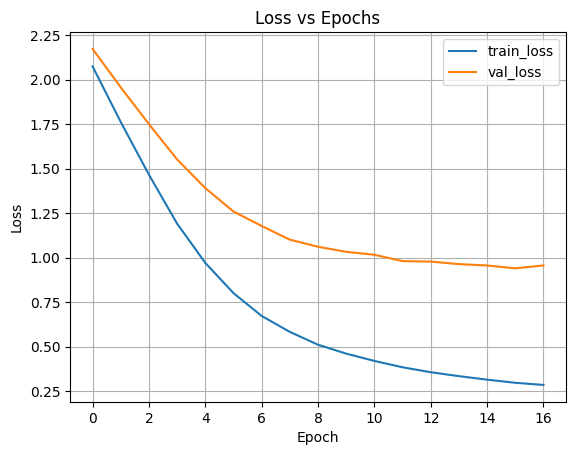

In [142]:
early_stop_train_loss = model_earlystop.train_loss
early_stop_val_loss = model_earlystop.val_loss
plot_loss(early_stop_train_loss, early_stop_val_loss)

In [143]:
model_earlystop.test(DTest)

Test Accuracy =  73.34 




### *Overfitting*

In [150]:
split_data = DataSplit(Data, 0.1, 98.9, 1 )
### *Config - 1 (1 Hidden Layer with 350 neurons)*
# Train and Test Data
DTrain = split_data[0]
DTest = split_data[1]
# Validataion Data
if len(split_data) == 3:
    DVal = split_data[2]

In [151]:
print(DTrain.shape)
print(DVal.shape)
print(DTest.shape)

(60, 785)
(600, 785)
(59340, 785)


In [152]:
input_channels = 1
conv_filters = [4, 6]
conv_kernal_size = 3
pool_kernal_size = 2
fc_layer_inputs = 5 * 5 * 6
output_neurons = 10
epochs = 100
batch_size = 256
learning_rate = 0.001

model_overfit = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [153]:
model_overfit.train_overfit(DTrain, epochs, batch_size, DVal)

Epoch:  1 Train Accuracy:  13.33 Train Loss:  6.287174145902356
Epoch:  1 Val Accuracy:  1.17 Val Loss:  5.747952918913525


Epoch:  2 Train Accuracy:  28.33 Train Loss:  5.752713717637033
Epoch:  2 Val Accuracy:  3.83 Val Loss:  4.774600293835869


Epoch:  3 Train Accuracy:  40.0 Train Loss:  4.140651058432074
Epoch:  3 Val Accuracy:  2.17 Val Loss:  3.8614944842359438


Epoch:  4 Train Accuracy:  35.0 Train Loss:  2.5864395061078462
Epoch:  4 Val Accuracy:  4.0 Val Loss:  2.7482163090980203


Epoch:  5 Train Accuracy:  53.33 Train Loss:  1.5876461353321798
Epoch:  5 Val Accuracy:  4.0 Val Loss:  2.1617693477053135


Epoch:  6 Train Accuracy:  61.67 Train Loss:  1.2953273668082066
Epoch:  6 Val Accuracy:  6.0 Val Loss:  1.6591397451665773


Epoch:  7 Train Accuracy:  73.33 Train Loss:  0.6767385370051342
Epoch:  7 Val Accuracy:  7.0 Val Loss:  0.8789033319098254


Epoch:  8 Train Accuracy:  70.0 Train Loss:  0.8416479174717003
Epoch:  8 Val Accuracy:  7.0 Val Loss:  1.2008627782257277

Epoch:  64 Val Accuracy:  8.5 Val Loss:  0.29892841005381793


Epoch:  65 Train Accuracy:  100.0 Train Loss:  0.02081627449682152
Epoch:  65 Val Accuracy:  8.67 Val Loss:  0.2982932781272157


Epoch:  66 Train Accuracy:  100.0 Train Loss:  0.020495980975638976
Epoch:  66 Val Accuracy:  9.17 Val Loss:  0.29767431748507783


Epoch:  67 Train Accuracy:  100.0 Train Loss:  0.02018546655044863
Epoch:  67 Val Accuracy:  8.83 Val Loss:  0.2970710935249935


Epoch:  68 Train Accuracy:  100.0 Train Loss:  0.01988438416999982
Epoch:  68 Val Accuracy:  8.5 Val Loss:  0.2964772839192363


Epoch:  69 Train Accuracy:  100.0 Train Loss:  0.019592312900916797
Epoch:  69 Val Accuracy:  9.0 Val Loss:  0.29589724897854713


Epoch:  70 Train Accuracy:  100.0 Train Loss:  0.019308786097645105
Epoch:  70 Val Accuracy:  9.17 Val Loss:  0.2953312664748759


Epoch:  71 Train Accuracy:  100.0 Train Loss:  0.019033559751132585
Epoch:  71 Val Accuracy:  9.33 Val Loss:  0.29477642441314506


Epoch:  72 Train Accur

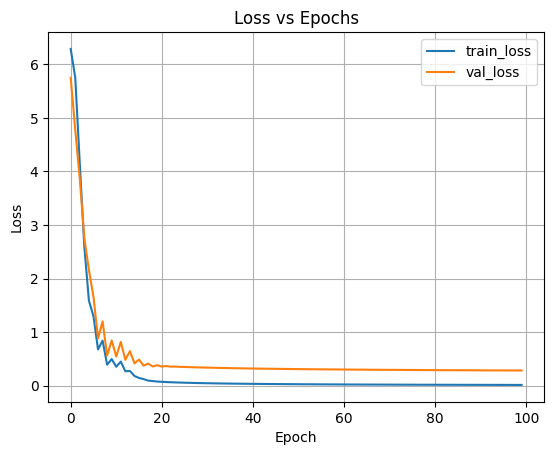

In [154]:
overfit_train_loss = model_overfit.train_loss
overfit_val_loss = model_overfit.val_loss
plot_loss(overfit_train_loss, overfit_val_loss)

In [155]:
model_overfit.test(DTest)

Test Accuracy =  73.32 




### *L2 Regularizer*

In [156]:
input_channels = 1
conv_filters = [4, 6]
conv_kernal_size = 3
pool_kernal_size = 2
fc_layer_inputs = 5 * 5 * 6
output_neurons = 10
epochs = 100
batch_size = 256
learning_rate = 0.001
regularizer = 0.01

model_l2reg = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [157]:
model_l2reg.train_l2reg(DTrain, epochs, batch_size, DVal, regularizer)

Epoch:  1 Train Accuracy:  11.67 Train Loss:  7.098531164380086
Epoch:  1 Val Accuracy:  3.0 Val Loss:  9.06146804528381


Epoch:  2 Train Accuracy:  35.0 Train Loss:  10.589186816197177
Epoch:  2 Val Accuracy:  2.5 Val Loss:  11.20945358241252


Epoch:  3 Train Accuracy:  35.0 Train Loss:  6.478687661950379
Epoch:  3 Val Accuracy:  2.0 Val Loss:  6.805378759403942


Epoch:  4 Train Accuracy:  33.33 Train Loss:  3.837500021515986
Epoch:  4 Val Accuracy:  2.5 Val Loss:  4.979303707493546


Epoch:  5 Train Accuracy:  31.67 Train Loss:  3.0160796434968833
Epoch:  5 Val Accuracy:  4.5 Val Loss:  4.1607561510230555


Epoch:  6 Train Accuracy:  55.0 Train Loss:  1.7883584731418594
Epoch:  6 Val Accuracy:  5.33 Val Loss:  2.545327623255332


Epoch:  7 Train Accuracy:  61.67 Train Loss:  0.7375300816297501
Epoch:  7 Val Accuracy:  6.67 Val Loss:  1.3312166401824808


Epoch:  8 Train Accuracy:  76.67 Train Loss:  0.32749682001790364
Epoch:  8 Val Accuracy:  7.0 Val Loss:  0.8280190026374952


E

Epoch:  64 Val Accuracy:  9.17 Val Loss:  0.3231210103690961


Epoch:  65 Train Accuracy:  100.0 Train Loss:  0.02939819334827575
Epoch:  65 Val Accuracy:  9.0 Val Loss:  0.3220210954278457


Epoch:  66 Train Accuracy:  100.0 Train Loss:  0.028933755611934512
Epoch:  66 Val Accuracy:  8.67 Val Loss:  0.32094329219281903


Epoch:  67 Train Accuracy:  100.0 Train Loss:  0.028479030137297467
Epoch:  67 Val Accuracy:  9.0 Val Loss:  0.31986609654247433


Epoch:  68 Train Accuracy:  100.0 Train Loss:  0.02804146899526168
Epoch:  68 Val Accuracy:  9.33 Val Loss:  0.31883191574289954


Epoch:  69 Train Accuracy:  100.0 Train Loss:  0.02761803074809009
Epoch:  69 Val Accuracy:  9.5 Val Loss:  0.3178261142337659


Epoch:  70 Train Accuracy:  100.0 Train Loss:  0.0272042736762785
Epoch:  70 Val Accuracy:  8.67 Val Loss:  0.3168295851073609


Epoch:  71 Train Accuracy:  100.0 Train Loss:  0.026802098387663443
Epoch:  71 Val Accuracy:  8.83 Val Loss:  0.3158536560189294


Epoch:  72 Train Accuracy

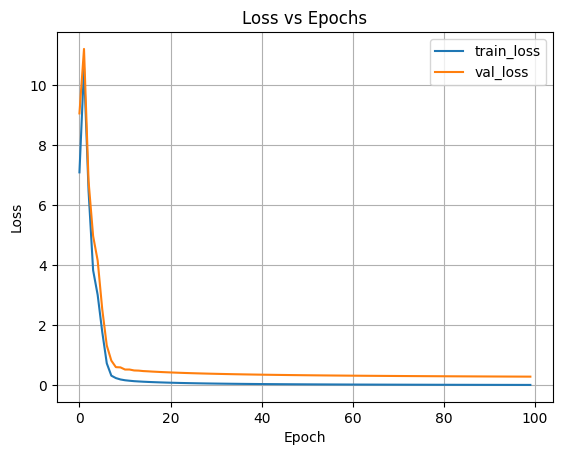

In [158]:
l2reg_train_loss = model_l2reg.train_loss
l2reg_val_loss = model_l2reg.val_loss
plot_loss(l2reg_train_loss, l2reg_val_loss)

In [159]:
model_l2reg.test(DTest)

Test Accuracy =  68.1 




### *Gaussian Noise*

In [160]:
Data = np.array(results)
labels = np.unique(Data[:,0].astype(int))
input_features = Data.shape[1] - 1

In [161]:
Image = np.delete(Data, 0, axis = 1)
# Define the mean and standard deviation of the Gaussian noise
mean = 0
stddev = 25
# Generate Gaussian noise with the same shape as the image
noise = np.random.normal(mean, stddev, Image.shape)
Noisy_image = noise + Image
Noisy_image = np.clip(Noisy_image, 0, 255)
Noisy_Data = np.zeros(Data.shape)
Noisy_Data[:, 0] = Data[:, 0]
Noisy_Data[:, 1:] = Data[:, 1:]

In [162]:
split_data = DataSplit(Noisy_Data, 0.1, 98.9, 1)
### *Config - 1 (1 Hidden Layer with 350 neurons)*
# Train and Test Data
DTrain = split_data[0]
DTest = split_data[1]
# Validataion Data
if len(split_data) == 3:
    DVal = split_data[2]

In [163]:
print(DTrain.shape)
print(DVal.shape)

(60, 785)
(600, 785)


In [164]:
input_channels = 1
conv_filters = [4, 6]
conv_kernal_size = 3
pool_kernal_size = 2
fc_layer_inputs = 5 * 5 * 6
output_neurons = 10
epochs = 100
batch_size = 256
learning_rate = 0.001

model_overfit = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [165]:
model_overfit.train_overfit(DTrain, epochs, batch_size, DVal)

Epoch:  1 Train Accuracy:  10.0 Train Loss:  5.024597656876406
Epoch:  1 Val Accuracy:  1.67 Val Loss:  5.164457935208613


Epoch:  2 Train Accuracy:  20.0 Train Loss:  3.95904473061712
Epoch:  2 Val Accuracy:  3.33 Val Loss:  4.2765126433434775


Epoch:  3 Train Accuracy:  26.67 Train Loss:  3.508849872758662
Epoch:  3 Val Accuracy:  4.0 Val Loss:  3.9478839492848072


Epoch:  4 Train Accuracy:  56.67 Train Loss:  2.2556016506707404
Epoch:  4 Val Accuracy:  5.5 Val Loss:  2.5026862995953607


Epoch:  5 Train Accuracy:  51.67 Train Loss:  1.8865288384207668
Epoch:  5 Val Accuracy:  4.67 Val Loss:  2.2718679126169468


Epoch:  6 Train Accuracy:  50.0 Train Loss:  1.652422249370994
Epoch:  6 Val Accuracy:  6.33 Val Loss:  1.964959337378291


Epoch:  7 Train Accuracy:  76.67 Train Loss:  0.9233891457532867
Epoch:  7 Val Accuracy:  6.5 Val Loss:  1.2264349190643928


Epoch:  8 Train Accuracy:  71.67 Train Loss:  0.5962562661713053
Epoch:  8 Val Accuracy:  7.17 Val Loss:  0.873243575585238


Epoch:  64 Val Accuracy:  9.33 Val Loss:  0.3072252234925685


Epoch:  65 Train Accuracy:  100.0 Train Loss:  0.02518329886201092
Epoch:  65 Val Accuracy:  8.5 Val Loss:  0.3066586664691266


Epoch:  66 Train Accuracy:  100.0 Train Loss:  0.024792513835160325
Epoch:  66 Val Accuracy:  8.67 Val Loss:  0.3061054270803607


Epoch:  67 Train Accuracy:  100.0 Train Loss:  0.02441479830097143
Epoch:  67 Val Accuracy:  9.67 Val Loss:  0.3055687135528358


Epoch:  68 Train Accuracy:  100.0 Train Loss:  0.02404871467181458
Epoch:  68 Val Accuracy:  8.83 Val Loss:  0.3050504249180953


Epoch:  69 Train Accuracy:  100.0 Train Loss:  0.023693883798132923
Epoch:  69 Val Accuracy:  9.17 Val Loss:  0.30455975323009726


Epoch:  70 Train Accuracy:  100.0 Train Loss:  0.023349553186105813
Epoch:  70 Val Accuracy:  9.17 Val Loss:  0.304068862877322


Epoch:  71 Train Accuracy:  100.0 Train Loss:  0.02301494965782614
Epoch:  71 Val Accuracy:  9.17 Val Loss:  0.30359455404396235


Epoch:  72 Train Accurac

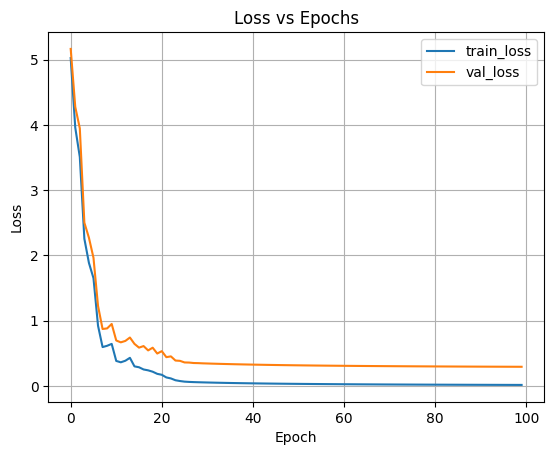

In [166]:
overfit_noise_train_loss = model_overfit.train_loss
overfit_noise_val_loss = model_overfit.val_loss
plot_loss(overfit_noise_train_loss, overfit_noise_val_loss)

In [167]:
model_overfit.test(DTest)

Test Accuracy =  70.81 




### *Comparing validation losses*

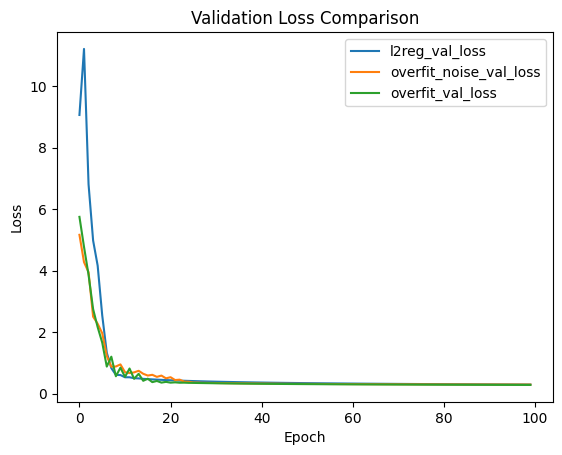

In [168]:
plt.plot(l2reg_val_loss, label = 'l2reg_val_loss')
plt.plot(overfit_noise_val_loss, label = 'overfit_noise_val_loss')
plt.plot(overfit_val_loss, label = 'overfit_val_loss')

# add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# show the plot
plt.show()